Code for project: Extragalactic Confusion Foreground
==

1. Catagorization for Potential Gravitational Sources(GWGC);
2. Compute GW power spectrum for baseline galaxies;
3. Compute extragalactic GW confusion foreground. 

Part 1: Catagorization of GWGC
===

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.table import Table, join, vstack
from astropy.io import ascii
import GW_calcs
import MW_maker

Source data: \
Gravitational Wave Galaxy Catalog (White et al. 2011) \
https://ui.adsabs.harvard.edu/abs/2011CQGra..28h5016W/abstract

  PGC               Name               RAhour   DEdeg   ... e_Dist e_Bmag e_BMAG
                                         h       deg    ...  Mpc    mag    mag  
------- ---------------------------- --------- -------- ... ------ ------ ------
      2 UGC12889                       0.00047  47.2745 ...  10.87   0.61   0.61
      4 PGC000004                      0.00096  23.0876 ...  13.92   0.39   0.40
      6 PGC000006                      0.00058  15.8817 ...  18.52   0.34   0.35
      7 PGC000007                      0.00122  -0.0833 ...  21.42   0.33   0.34
     10 PGC000010                      0.00217  -0.0406 ...  21.61   0.29   0.31
     12 PGC000012                      0.00240  -6.3739 ...  13.82   0.36   0.37
     13 PGC000013                      0.00370  33.1342 ...  10.91   0.40   0.41
     16 PGC000016                      0.00314  -5.1587 ...  11.89   0.29   0.30
     18 PGC000018                      0.00360  46.9651 ...  11.60   0.31   0.32
     31 PGC000031           

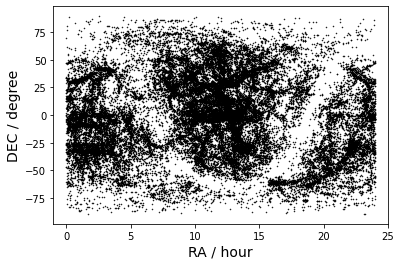

In [2]:
# ==============
# Read GWGC Data
# ==============

data_path = './DATA/'
data_save_path = './generated_data/'

# Import GWGC Data
GWGC = fits.open(data_path + 'VII_267_gwgc.dat.gz.fits')
GWGC = Table.read(data_path + 'VII_267_gwgc.dat.gz.fits')

# Select data with non-zero Bmag
mask = GWGC['Bmag'] != 0
GWGC = GWGC[mask]
print(GWGC)

# Adding two columns for M-to-L and Estimated Mass
GWGC['M_to_L'] = np.zeros(len(GWGC)) - 1
GWGC['EST_M'] = np.zeros(len(GWGC)) - 1

# Galaxy sky locations
plt.plot(GWGC['RAhour'], GWGC['DEdeg'], 'k.', markersize = 1)
plt.xlim(-1, 25)
plt.xlabel('RA / hour', fontsize=14)
plt.ylabel('DEC / degree', fontsize=14)
plt.show()

In [3]:
# ==============================
# Estimating Galaxy Stellar Mass
# ==============================
'''
Applying mass-to-light ratio condtions to the catalog data from 
Faber and Gallagher (1979).
'''

# Catagorization of galaxies
# Devide GWGC catalog to 7 groups of galaxy following Faber (1979)

GWGC_mk = GWGC[np.where(GWGC['TT'] == -9.)] # Milky-Way
GWGC_1 = GWGC[np.where((GWGC['TT'] >= -6.) & (GWGC['TT'] < -4.))]
GWGC_2 = GWGC[np.where((GWGC['TT'] >= -4.) & (GWGC['TT'] < -2.))]
GWGC_3 = GWGC[np.where((GWGC['TT'] >= -2.) & (GWGC['TT'] < 1.))]
GWGC_4 = GWGC[np.where((GWGC['TT'] >= 1.)  & (GWGC['TT'] < 4.))]
GWGC_5 = GWGC[np.where((GWGC['TT'] >= 4.)  & (GWGC['TT'] < 5.))]
GWGC_6 = GWGC[np.where((GWGC['TT'] >= 5.)  & (GWGC['TT'] < 8.))]
GWGC_7 = GWGC[np.where((GWGC['TT'] >= 8.)  & (GWGC['TT'] < 10))]

print('Number of galaxies in the catalog:', len(GWGC))
print('Number of members in each group:',
      len(GWGC_mk), len(GWGC_1), len(GWGC_2), len(GWGC_3), 
      len(GWGC_4),  len(GWGC_5), len(GWGC_6), len(GWGC_7))

# Assign Mass-to-light ratio to the catalog
'''
Blue luminosity in the unit of 10^10 solar luminosity
Mass-to-light ratio in the standard system - m_solar / L_solar
Estimated mass in the unit of m_solar
'''
GWGC_1['M_to_L'] = 8.5
GWGC_2['M_to_L'] = 9.5
GWGC_3['M_to_L'] = 6.2
GWGC_4['M_to_L'] = 6.5
GWGC_5['M_to_L'] = 4.7
GWGC_6['M_to_L'] = 3.9
GWGC_7['M_to_L'] = 1.7

# Assign group number
GWGC_1['TYPE'] = 1
GWGC_2['TYPE'] = 2
GWGC_3['TYPE'] = 3
GWGC_4['TYPE'] = 4
GWGC_5['TYPE'] = 5
GWGC_6['TYPE'] = 6
GWGC_7['TYPE'] = 7

GWGC_with_mass = vstack([GWGC_1, GWGC_2, GWGC_3, GWGC_4, GWGC_5, GWGC_6, GWGC_7])
GWGC_with_mass['EST_M'] = (abs(GWGC_with_mass['Bmag'] * 
                               GWGC_with_mass['M_to_L']) * 1e10 * u.solMass)

# Galaxy Stellar Mass
# The ratio of galaxy stellar mass and total mass STR
STR = 6.43/129
GWGC_with_mass['EST_STELLAR_M'] = GWGC_with_mass['EST_M'] * STR

Number of galaxies in the catalog: 49300
Number of members in each group: 116 1415 1614 28963 5529 2285 6145 2446


range of Stellar Mass = 245735659 - 87649872093


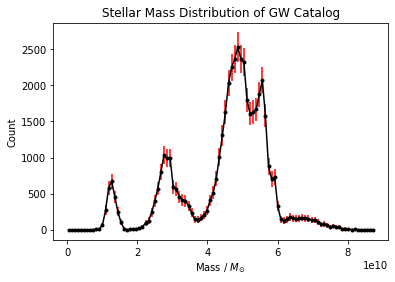

In [4]:
# =============================
# Galaxy Catalog Characteristic
# =============================

# Mass distribution
print('range of Stellar Mass =', 
      format(min(GWGC_with_mass['EST_STELLAR_M']), '.0f'), '-', 
      format(max(GWGC_with_mass['EST_STELLAR_M']), '.0f'))

bins = 100
N, mass = np.histogram(GWGC_with_mass['EST_STELLAR_M'], bins, 
                       range = (0, max(GWGC_with_mass['EST_STELLAR_M'])))
mass_mid = (mass[1:] + mass[:-1]) / 2

plt.errorbar(mass_mid, N, yerr = 4*np.sqrt(N), fmt = 'k.', linestyle = '-', ecolor = 'r')
plt.xlabel('Mass / $M_{\odot}$')
plt.ylabel('Count')
plt.title('Stellar Mass Distribution of GW Catalog')
plt.savefig('figures/'+'Stellar_Mass_Distribution.png')
plt.show()

In [5]:
# ===========================
# Estimate Galaxy Metallicity
# ===========================

# Estimate Galaxy Metallicity from Tremonti 2004 MZ Relation
Z_log12 = (-1.492 + 1.847*np.log10(GWGC_with_mass['EST_STELLAR_M']) 
          - 0.0826*np.log10(GWGC_with_mass['EST_STELLAR_M'])**2) 

# Converge 12+log(O/H) form to primordial metallicity
Z = 33.8286 * 10**(Z_log12 - 12) 
GWGC_COMPLETE = GWGC_with_mass # Final table for GWGC analysis

# Change galaxy mass to 10_12 solar mass
GWGC_COMPLETE['EST_STELLAR_M'] = np.round(GWGC_with_mass['EST_STELLAR_M'], decimals = 4)
GWGC_COMPLETE['EST_Z'] = np.round(Z, decimals = 4)

# Construct table for further use
# Take useful information from GWGC
GWGC_COMPLETE = GWGC_COMPLETE['PGC', 'Name', 'RAhour', 'DEdeg', 'TT', 'Bmag', 
                              'Dist', 'EST_STELLAR_M','EST_Z', 'TYPE']

ascii.write(GWGC_COMPLETE, data_save_path+'GWGC_COMPLETE.csv', 
            format='basic', fast_writer=False)

Range of Metallicity: 0.0052 0.0228


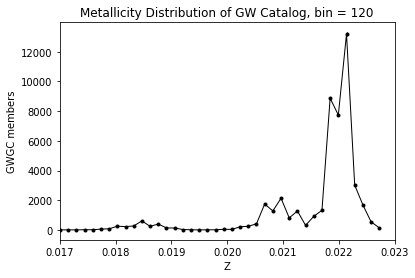

In [6]:
# ========================
# Metallicity Distribution
# ========================
bins = 120
min_Z = min(GWGC_COMPLETE['EST_Z'])
max_Z = max(GWGC_COMPLETE['EST_Z'])

N, Z = np.histogram(GWGC_COMPLETE['EST_Z'], bins, range = (min_Z, max_Z))
Z_mid = (Z[1:] + Z[:-1])/2
plt.errorbar(Z_mid, N, yerr = np.sqrt(N), fmt = 'k.', 
             linestyle = '-', linewidth = 1, ecolor = 'k')
print('Range of Metallicity:', min_Z, max_Z)

plt.xlim(0.017, 0.023)
plt.xlabel('Z')
plt.ylabel('GWGC members')
plt.title('Metallicity Distribution of GW Catalog, bin = 120')
plt.show()

Members of complete catalog: 
 48397 Z = 0.0217 std = 0.0009 

Members of group 1 : 1415 Z = 0.0224 std = 0.0002
Members of group 2 : 1614 Z = 0.0225 std = 0.0001
Members of group 3 : 28963 Z = 0.0221 std = 0.0002
Members of group 4 : 5529 Z = 0.0219 std = 0.0002
Members of group 5 : 2285 Z = 0.0212 std = 0.0002
Members of group 6 : 6145 Z = 0.0208 std = 0.0002
Members of group 7 : 2446 Z = 0.0184 std = 0.0005


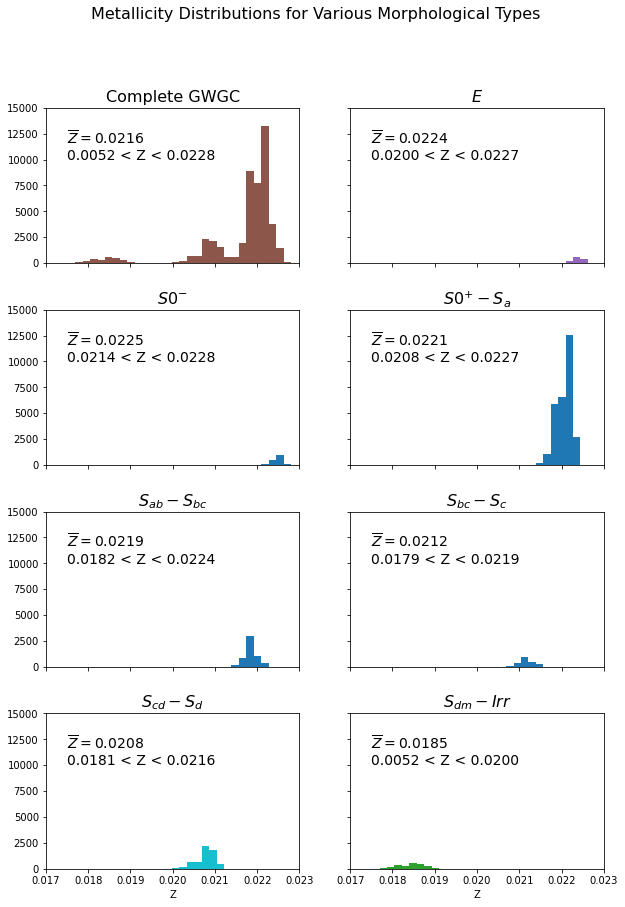

In [7]:
# ================================================
# Metallicity Distribution for 7 types of galaxies
# ================================================

groups = [[], [], [], [], [], [], []]
for i in range(len(groups)):
    groups[i] = GWGC_COMPLETE[np.where(GWGC_COMPLETE['TYPE'] == i+1)]

# Print parameters of each group
print('Members of complete catalog:', '\n',
      len(GWGC_COMPLETE), 'Z =', round(np.mean(GWGC_COMPLETE['EST_Z']), 4), 
      'std =', round(np.std(GWGC_COMPLETE['EST_Z']), 4), '\n')

for j in range(len(groups)):
    print('Members of group', j+1, ':',
          len(groups[j]), 'Z =', round(np.mean(groups[j]['EST_Z']), 4), 
          'std =', round(np.std(groups[j]['EST_Z']), 4))
    
# Plot Metallicity distribution for each group
fig, ((ax1, ax2), 
      (ax3, ax4), 
      (ax5, ax6), 
      (ax7, ax8)) = plt.subplots(4, 2, sharey = False, 
                                 gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, 
                                 figsize = (10, 14))
fig.suptitle('Metallicity Distributions for Various Morphological Types', fontsize = 16)
bins = 100

# Complete distribution of metallicity
ax1.hist(GWGC_COMPLETE['EST_Z'], bins, range = (min_Z, max_Z), color='tab:brown')
ax1.set_title('Complete GWGC', fontsize=16)
ax1.text(0.0175, 11500, r'$\overline{Z} = 0.0216$', fontsize=14)
ax1.text(0.0175, 10000, r'0.0052 < Z < 0.0228', fontsize=14)

# 1st type of galaxy
groups[0]['GROUP'] = 1 # Assign group number
ax2.hist(groups[0]['EST_Z'], bins, range = (min_Z, max_Z), color='tab:purple')
ax2.set_title('$E$', fontsize=16)
ax2.text(0.0175, 11500, r'$\overline{Z} = 0.0224$', fontsize=14)
ax2.text(0.0175, 10000, r'0.0200 < Z < 0.0227', fontsize=14)

# 2nd type of galaxy
groups[1]['GROUP'] = 2 # Assign group number
ax3.hist(groups[1]['EST_Z'], bins, range = (min_Z, max_Z), color='tab:blue')
ax3.set_title('$S0^{-}$', fontsize=16)
ax3.text(0.0175, 11500, r'$\overline{Z} = 0.0225$', fontsize=14)
ax3.text(0.0175, 10000, r'0.0214 < Z < 0.0228', fontsize=14)

# 3rd type of galaxy
groups[2]['GROUP'] = 2 # Assign group number
ax4.hist(groups[2]['EST_Z'], bins, range = (min_Z, max_Z), color='tab:blue')
ax4.set_title('$S0^{+} - S_a$', fontsize=16)
ax4.text(0.0175, 11500, r'$\overline{Z} = 0.0221$', fontsize=14)
ax4.text(0.0175, 10000, r'0.0208 < Z < 0.0227', fontsize=14)

# 4th type of galaxy
groups[3]['GROUP'] = 2 # Assign group number
ax5.hist(groups[3]['EST_Z'], bins, range = (min_Z, max_Z), color='tab:blue')
ax5.set_title('$S_{ab} - S_{bc}$', fontsize=16)
ax5.text(0.0175, 11500, r'$\overline{Z} = 0.0219$', fontsize=14)
ax5.text(0.0175, 10000, r'0.0182 < Z < 0.0224', fontsize=14)

# 5th type of galaxy
groups[4]['GROUP'] = 2 # Assign group number
ax6.hist(groups[4]['EST_Z'], bins, range = (min_Z, max_Z), color='tab:blue')
ax6.set_title('$S_{bc} - S_c$', fontsize=16)
ax6.text(0.0175, 11500, r'$\overline{Z} = 0.0212$', fontsize=14)
ax6.text(0.0175, 10000, r'0.0179 < Z < 0.0219', fontsize=14)

# 6th type of galaxy
groups[5]['GROUP'] = 3 # Assign group number
ax7.hist(groups[5]['EST_Z'], bins, range = (min_Z, max_Z), color='tab:cyan')
ax7.set_title('$S_{cd} - S_d$', fontsize=16)
ax7.text(0.0175, 11500, r'$\overline{Z} = 0.0208$', fontsize=14)
ax7.text(0.0175, 10000, r'0.0181 < Z < 0.0216', fontsize=14)

# 7th type of galaxy
groups[6]['GROUP'] = 4 # Assign group number
ax8.hist(groups[6]['EST_Z'], bins, range = (min_Z, max_Z), color='tab:green')
ax8.set_title('$S_{dm} - Irr$', fontsize=16)
ax8.text(0.0175, 11500, r'$\overline{Z} = 0.0185$', fontsize=14)
ax8.text(0.0175, 10000, r'0.0052 < Z < 0.0200', fontsize=14)

# Plotting styles
ax7.set(xlabel='Z')
ax8.set(xlabel='Z')
for ax in fig.get_axes():
    ax.label_outer()
for ax in fig.get_axes():
    ax.set_xlim(0.017, 0.023)
for ax in fig.get_axes():
    ax.set_ylim(0, 15000)

In [8]:
# =================================
# Galaxy Metallicity categorization
# =================================

# Metallicity Z for each catagory
print('Metallicity for each catalog:', '\n')

# 1 Elliptical galaxy
print(np.mean(groups[0]['EST_Z']))

# 2 Spiral galaxy
print(np.mean(np.concatenate((groups[1]['EST_Z'], groups[2]['EST_Z'], groups[3]['EST_Z'], groups[4]['EST_Z']))))

# 3 S_cd - S_d
print(np.mean(groups[5]['EST_Z']))

# 4 Irragular galaxy
print(np.mean(groups[6]['EST_Z']))

# Generate table for DATA_ANALISYS
GWGC_COMPLETE_Categorized = vstack(groups)

# Converge table into Pandas DataFrame
# Painful, but nessesary for the consistency with COSMIC data
import pandas as pd

GWGC_pd = GWGC_COMPLETE_Categorized.to_pandas()
GWGC_pd.to_csv(data_save_path+'GWGC_COMPLETE_Categorized.csv')

Metallicity for each catalog: 

0.022357243816254417
0.021990359719725978
0.02076211554109032
0.018441169255928046


,PGC,Name,RAhour,DEdeg,TT,Bmag,Dist,EST_STELLAR_M,EST_Z,TYPE,GROUP
0,595,b'NGC0005 ',0.13025,35.3623,-4.9,14.39,72.14,6.096786e+10,0.0224,1,1
1,708,b'PGC000708 ',0.16857,-36.7751,-5.0,14.69,95.35,6.223891e+10,0.0224,1,1
2,1037,b'NGC0057 ',0.25857,17.3284,-4.9,12.28,77.85,5.202817e+10,0.0221,1,1
3,1185,b'PGC001185 ',0.30411,30.0632,-5.0,15.79,93.94,6.689941e+10,0.0225,1,1
4,1206,b'PGC001206 ',0.31003,-6.3013,-5.0,14.89,89.99,6.308628e+10,0.0224,1,1
...,...,...,...,...,...,...,...,...,...,...,...
48392,4079410,b'6dFJ0410498-272959 ',4.18049,-27.4998,9.0,19.45,46.79,1.648124e+10,0.0193,7,4
48393,4215191,b'SDSSJ095100.45+200420.9 ',9.85013,20.0725,9.0,17.55,49.44,1.487124e+10,0.0190,7,4
48394,4231240,b'SDSSJ101726.52+292210.6 ',10.29070,29.3696,8.0,16.23,7.96,1.375272e+10,0.0187,7,4
48395,4581793,b'PGC4581793 ',11.61493,17.8904,8.0,18.02,47.75,1.526951e+10,0.0191,7,4


Part 2: Gravitational Wave Power Spectrum
==

In [9]:
from cosmic import MC_samp
import numpy as np
import pandas as pd
import GW_calcs
import MW_maker
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import colors
# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

Tobs = 8
SNR_lim = 7

# Data path and date file
data_path = './DATA/'
data_save_path = './generated_data/'

In [55]:
# ================================
# Read the COSMIC fixed population
# ================================

file_name_1 = 'dat_kstar1_10_13_kstar2_10_13_SFstart_10000_SFduration_0_metallicity_0.0223.h5'
file_name_2 = 'dat_kstar1_10_13_kstar2_10_13_SFstart_11000_SFduration_0_metallicity_0.0185.h5'
file_name_3 = 'dat_kstar1_10_13_kstar2_10_13_SFstart_11000_SFduration_0_metallicity_0.0208.h5'
file_name_4 = 'dat_kstar1_10_13_kstar2_10_13_SFstart_11000_SFduration_0_metallicity_0.022.h5'
file_names = [file_name_1, file_name_2, file_name_3, file_name_4]

# Set the base-model astrophysical mass
m_astro = 1e10   # <===== Baseline astrophysical mass (solar mass)
base_dist = 1000 # <===== Baseline astrophysical distance (kpc)

# Generate astrophysical binary population
conv = [[], [], [], []]
n_astro = np.ones(len(conv))
m_sim_tot = np.ones(len(conv))

for i in range(len(convs)):
    conv[i] = pd.read_hdf(data_path + file_names[i], key='conv')
    
    # Filter binaries fall into the roche lobe
    print('Dataset', i+1, '\n', 'conv:', len(conv[i]))
    conv[i] = conv[i][conv[i]['sep'] > conv[i]['rad_1']/conv[i]['RRLO_1'] + 
                                       conv[i]['rad_2']/conv[i]['RRLO_2']]
    print('', 'stable:', len(conv[i]))
    
    # Compute total mass of fixed pop
    m_sim = pd.read_hdf(data_path + file_names[i], key='mass_stars')
    m_sim_tot[i] = m_sim.max()[0]
    
    # Find galaxy astrophysical stellar pop
    n_astro[i] = int(len(conv[i]) * m_astro / m_sim_tot[i])
    print('', 'astro:', n_astros[i], '\n')

Dataset 1 
 conv: 215722
 stable: 215672
 astro: 124636214.0 

Dataset 2 
 conv: 214174
 stable: 214116
 astro: 135872339.0 

Dataset 3 
 conv: 203287
 stable: 203231
 astro: 132985687.0 

Dataset 4 
 conv: 207601
 stable: 207557
 astro: 131710172.0 



In [69]:
print(conv[0].columns)
print(conv[0])

Index(['bin_num', 'tphys', 'mass_1', 'mass_2', 'kstar_1', 'kstar_2', 'sep',
       'porb', 'ecc', 'RRLO_1', 'RRLO_2', 'evol_type', 'aj_1', 'aj_2', 'tms_1',
       'tms_2', 'massc_1', 'massc_2', 'rad_1', 'rad_2', 'mass0_1', 'mass0_2',
       'lum_1', 'lum_2', 'teff_1', 'teff_2', 'radc_1', 'radc_2', 'menv_1',
       'menv_2', 'renv_1', 'renv_2', 'omega_spin_1', 'omega_spin_2', 'B_1',
       'B_2', 'bacc_1', 'bacc_2', 'tacc_1', 'tacc_2', 'epoch_1', 'epoch_2',
       'bhspin_1', 'bhspin_2'],
      dtype='object')
      bin_num        tphys    mass_1    mass_2  kstar_1  kstar_2  \
0           1  4281.039583  0.585994  0.540880     11.0     11.0   
1           3  2400.574829  0.676474  0.572557     11.0     11.0   
2           9  2260.240582  0.593967  0.571966     11.0     11.0   
3          11  1272.910151  0.665417  0.605634     11.0     11.0   
4          15   486.651690  0.840083  0.766921     11.0     11.0   
...       ...          ...       ...       ...      ...      ...   
1459  145

In [70]:
# ===================================
# Generating galaxy binary population
# (This may take a while, ~30 min)
# (Run with memory > 50G)
# ===================================

# Data path and date file
data_path = './DATA/'
data_save_path = './generated_data/'

# Set the base-model astrophysical mass
# Assume it to be 1e10 solar mass, 1 Mpc, scale back later!
glx_pop_file_name = ['glx_pop_1.h5', 'glx_pop_2.h5', 'glx_pop_3.h5', 'glx_pop_4.h5']
model = 'ThickDisk'

for i in range(4):
    print('', 'pop', i+1, '\n', 
          'Conv pop num:', len(conv[i]), '\n', 
          'Conv pop mass:', m_sim_tot[i], '\n',
          'Astro pop num:', n_astro[i], '\n',
          'Generating galaxy pop', '...')
    
    glx_pop = MW_maker.LISA_Galaxy(conv=conv[i], 
                                   model=model, 
                                   m_sim_tot=m_sim_tot[i], 
                                   kstars='all stars')
    glx_pop.to_hdf(data_save_path + glx_pop_file_name[i], key='conv')
    print('Galaxy', i+1, 'done.', '\n')
print('Galaxy populaitons all done!')

 pop 1 
 Conv pop num: 215672 
 Conv pop mass: 17304119.90700576 
 Astro pop num: 124636214.0 
 Generating galaxy pop ...
The number of binaries in the population is: 179476148
filtered numbers 38328167


/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:312: RuntimeWarning: invalid value encountered in double_scalars
  a_evol = c_0*e_evol**(12./19)/(1-e_evol**2)*(1+(121./304)*e_evol**2)**(870./2299)
/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:315: RuntimeWarning: invalid value encountered in double_scalars
  c_0 = a_0*(1-e_0**2)*e_0**(-12./19)*(1+(121./304)*e_0**2)**(-870./2299)
/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:251: RuntimeWarning: invalid value encountered in double_scalars
  c_0 = a_0*(1-e_0**2)*e_0**(-12./19)*(1+(121./304)*e_0**2)**(-870./2299)
/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:257: RuntimeWarning: invalid value encountered in double_scalars
  nominator = e_0**(-29./19)*(1-e_0**2)**(3./2)


Galaxy 1 done. 

 pop 2 
 Conv pop num: 214116 
 Conv pop mass: 15758615.813292218 
 Astro pop num: 135872339.0 
 Generating galaxy pop ...
The number of binaries in the population is: 195656169
filtered numbers 40312576
Galaxy 2 done. 

 pop 3 
 Conv pop num: 203231 
 Conv pop mass: 15282170.85702444 
 Astro pop num: 132985687.0 
 Generating galaxy pop ...
The number of binaries in the population is: 191499390
filtered numbers 39796963
Galaxy 3 done. 

 pop 4 
 Conv pop num: 207557 
 Conv pop mass: 15758615.813292217 
 Astro pop num: 131710172.0 
 Generating galaxy pop ...
The number of binaries in the population is: 189662647
filtered numbers 39737804
Galaxy 4 done. 

Galaxy populaitons all done!


In [71]:
# =====================
# Compute GW LISA Power
# (~10 min)
# =====================
data_path = './generated_data/'

'''
Compute the base-model LISA power
Where:
Luminosity distance = 1000 kpc
Galaxy stellar mass = 1e10 solar mass

Notice:
Units in COSMIC differenct than GWGC
COSMIC[kpc] - GWGC[Mpc]
'''

# Load galaxy date files
glx_pop_1 = pd.read_hdf(data_path + 'glx_pop_1.h5', key='conv')
glx_pop_2 = pd.read_hdf(data_path + 'glx_pop_2.h5', key='conv')
glx_pop_3 = pd.read_hdf(data_path + 'glx_pop_3.h5', key='conv')
glx_pop_4 = pd.read_hdf(data_path + 'glx_pop_4.h5', key='conv')
glx_pops = [glx_pop_1, glx_pop_2, glx_pop_3, glx_pop_4]
print('Galaxy data file loaded.', '\n')

# Scale the simulation power to astrophysical parameter
model = 'ThickDisk'
m_ratios = [0, 0, 0, 0]

for i in range(4):
    #Counting binaries for pop
    n_pop = MC_samp.mass_weighted_number(component_mass=MC_samp.select_component_mass(model),
                                         dat=conv[i],
                                         total_sampled_mass=m_sim_tot[i])
    # astrophysical to simulation binary number ratio
    m_ratios[i] = n_astro[i]/n_pop
    print('', 'Astro to Sim m ratio:', round(m_ratios[i], 12))

# =================================
# Compute LISA Power
# (Take ~10 min, take another break)
# =================================
power_file_names = ['glx_power_1.h5', 'glx_power_2.h5', 'glx_power_3.h5', 'glx_power_4.h5']

print('\n', 'Begin computing LISA GW power.', '\n')

for j in range(4):
    print('Computing galaxy GW power', j+1, '...')
    glx_pop = glx_pops[j]
    m_ratio = m_ratios[j]
    power_file_name = power_file_names[j]
    glx_pop.dist = glx_pop.dist*0 + base_dist
    LISA_power = GW_calcs.LISA_power(glx_pop, Tobs)
    LISA_power.strain_2 = LISA_power.strain_2 * m_ratio
    LISA_power.to_hdf(data_path + power_file_name, key='power')
    print('Galaxy GW power', j+1, 'done.')

print('Galaxy GW powers all done!')

Galaxy data file loaded. 

 Astro to Sim m ratio: 0.694444445064
 Astro to Sim m ratio: 0.694444441463
 Astro to Sim m ratio: 0.694444441833
 Astro to Sim m ratio: 0.694444446934

 Begin computing LISA GW power. 

Computing galaxy GW power 1 ...


/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:585: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d=np.array(dat_circ.dist))**2
/projects/b1094/wyy6563/Extragalactic_confusion_foreground/GW_calcs.py:587: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_circ['digits'] = np.digitize(dat_circ.f_gw_peak, LISA_freq)


Galaxy GW power 1 done.
Computing galaxy GW power 2 ...
Galaxy GW power 2 done.
Computing galaxy GW power 3 ...
Galaxy GW power 3 done.
Computing galaxy GW power 4 ...
Galaxy GW power 4 done.
Galaxy GW powers all done!


Number of base-line model population: 25239975 25239975 25239975 25239975
Data imported. 



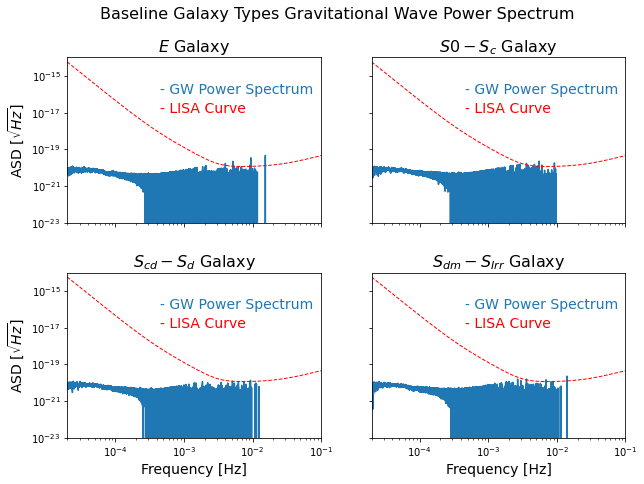

Group Power Spectrum Figure Saved.


<Figure size 432x288 with 0 Axes>

In [85]:
# ==========================================================
# Plot the total gravitational wave power of galaxy binaries
# against the LISA curve
# ==========================================================
from cosmic import MC_samp
import numpy as np
import pandas as pd
import GW_calcs
import MW_maker
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import colors
# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

Tobs = 8
SNR_lim = 7

data_path = './generated_data/'

# Import Data
LISA_PSD = GW_calcs.lisa_PSD()
LISA_power_1 = pd.read_hdf(data_path + 'glx_power_1.h5', key='power')
LISA_power_2 = pd.read_hdf(data_path + 'glx_power_2.h5', key='power')
LISA_power_3 = pd.read_hdf(data_path + 'glx_power_3.h5', key='power')
LISA_power_4 = pd.read_hdf(data_path + 'glx_power_4.h5', key='power')

print('Number of base-line model population:', 
      len(LISA_power_1), len(LISA_power_2), len(LISA_power_3), len(LISA_power_4))
print('Data imported.', '\n')

# Figure Parameters
fs = 14 # fontsize
fig, ((ax1, ax2), 
      (ax3, ax4)) = plt.subplots(2, 2, sharey = False, 
                                 gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize = (10, 7))
fig.suptitle('Baseline Galaxy Types Gravitational Wave Power Spectrum', fontsize = fs+2)

# Plotting Style
baselines = [LISA_power_1, LISA_power_2, LISA_power_3, LISA_power_4]
glx_names = ['$E$', '$S0 - S_c$', '$S_{cd} - S_d$','$S_{dm} - S_{Irr}$']
axs = [ax1, ax2, ax3, ax4]
text_x = 4.5e-4 # text location
text_y_up = 1e-16 # text location
text_y_dn = 1e-17 # text location
fs = 14 # fontsize
ax3.set_xlabel('Frequency [Hz]', fontsize=fs)
ax4.set_xlabel('Frequency [Hz]', fontsize=fs)
ax1.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)
ax3.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

# Plot the Grid
for i in range(4):
    axs[i].plot(baselines[i].f_gw, 
               (baselines[i].strain_2*Tobs*yr_sec)**0.5, color='tab:blue', rasterized=True)
    axs[i].plot(np.linspace(5e-6, 0.1, 10000), 
               (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')
    axs[i].set_title(glx_names[i]+' Galaxy', fontsize=fs+2)
    axs[i].text(text_x, text_y_up, 
                r'- '+'GW Power Spectrum', color = 'tab:blue', fontsize=fs)
    axs[i].text(text_x, text_y_dn, 
                r'- LISA Curve', color = 'red', fontsize=fs)

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(2e-5, 1e-1)
    ax.set_ylim(1e-23, 1e-14)
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.show()
save_plot_name = 'Baseline_GW_power_spec'
plt.savefig('figures/' + save_plot_name + '.png')
print('Group Power Spectrum Figure Saved.')

Part 3: Extragalactic GW Power Spectrum
==

In [86]:
from cosmic import MC_samp
import numpy as np
import pandas as pd
import GW_calcs
import MW_maker
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from IPython.display import clear_output

# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

data_path = './generated_data/'
data_save_path = './generated_data/'
Tobs = 8
SNR_lim = 7

In [206]:
# ============================================
# Import GWGC & Calculated LISA Power Spectrum
# ============================================

# Import GWGC cataglorized table
GWGC_original = pd.read_csv(data_path + 'GWGC_COMPLETE_Categorized.csv')
GWGC_original = GWGC_original.drop(['Unnamed: 0'], axis=1)

# Exclude Globular Clusters
GWGC = GWGC_original.loc[GWGC_original.Dist>4]
#GWGC = GWGC.append(GWGC_original[32160:32161]) #Add back M31
print('Exclude Globular Clusters:', len(GWGC_original)-len(GWGC))

# =========================================================
# Compute the total gravitational radiation power for Group
# =========================================================

# Galaxy categorization
'''
Have base-model the LISA Gravitational radiation power spectrum:
1. Luminosity distance = 1000 kpc = 1 Mpc, notice GWGC unit in Mpc
2. Galaxy stellar mass = 1e10 solar mass
'''

# Group GWGC following the categorization method
# (Save an additinoal loop)
GWGC_G1 = GWGC.loc[GWGC.GROUP == 1]
GWGC_G2 = GWGC.loc[GWGC.GROUP == 2]
GWGC_G3 = GWGC.loc[GWGC.GROUP == 3]
GWGC_G4 = GWGC.loc[GWGC.GROUP == 4]

# Reset index of GWGC group tables
# Important! Otherwise for-loop won't run
GWGC_G1 = GWGC_G1.reset_index()
GWGC_G2 = GWGC_G2.reset_index()
GWGC_G3 = GWGC_G3.reset_index()
GWGC_G4 = GWGC_G4.reset_index()

print('Number of members in the group:',
      len(GWGC_G1), len(GWGC_G2), len(GWGC_G3), len(GWGC_G4))

Exclude Globular Clusters: 117
Number of members in the group: 1383 38375 6130 2392


Sample data of Gravitational Wave Galaxy Catalog(GWGC) by White et al. 2010

GWGC Parameters:
1. PGC: Identifier from HYPERLEDA
2. Name: Common Galaxy Name
3. RA: Right ascension [hour]
4. DEC: Declination [degree]
5. TT: Galaxy Morphological Type [Hubble Sequence]
6. Bmag: Blue magnitude
7. Dist: Luminosity Distance [Mpc]

Computed data:
8. EST_STELLAR_M: Estimated galaxy stellar mass[$M_{odot}]
9. EST_Z: Estimated galaxy metallicity
10. Categorization label

In [88]:
# ===============================================
# Frequency shift & Birth time shift Relationship
# ===============================================

# Randomized frequency distribution
def f_shift(h, f_gw, t_shift, D):
    f_bin = 1/(Tobs*yr_sec)
    C = (5/1024 * G**(25/9) * c**(20/3) * np.pi**(16/3))
    return (((f_gw**(-8/3) - t_shift/(C*h*D))**(-3/8) - 
             f_gw)/f_bin).astype(int, errors='ignore') * f_bin

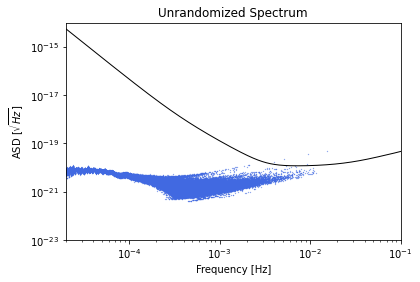

t_shift = -2.624064182898868 yr
LISA resolution = 3.961965134706815e-09
Max f shift = 0.0


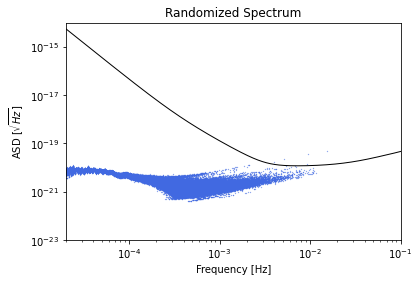

In [89]:
'''
Testing randomization process
for a single galaxy
'''

# ==============================================
# Power spectrum for base-model fixed population
# Check with galaxy power spectrum below
# ==============================================

# Import Gravitational Wave power spectrum data
power_file = 'glx_power_1.h5'
LISA_power = pd.read_hdf(data_path + power_file, key='power')

LISA_PSD = GW_calcs.lisa_PSD()
plt.plot(LISA_power.f_gw, (LISA_power.strain_2*Tobs*yr_sec)**0.5, 
         '.', markersize = 0.5, color='royalblue', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [$\sqrt{Hz}$]')
plt.title('Unrandomized Spectrum')
plt.show()

# =======================
# Testing...
# Frequency Randomization 
# =======================

D = 1e8*parsec
t_shift = np.random.normal(0, Tobs*yr_sec)
print('t_shift =', t_shift/yr_sec, 'yr')

LISA_power['f_gw_new'] = (LISA_power.f_gw + 
                          f_shift((LISA_power.strain_2)**0.5, LISA_power.f_gw, t_shift, D))
print('LISA resolution =', 1/(Tobs*yr_sec))
print('Max f shift =', np.max(LISA_power.f_gw_new - LISA_power.f_gw))

LISA_PSD = GW_calcs.lisa_PSD()
plt.plot(LISA_power.f_gw_new, (LISA_power.strain_2*Tobs*yr_sec)**0.5, 
         '.', markersize = 0.5, color='royalblue', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [$\sqrt{Hz}$]')
plt.title('Randomized Spectrum')
plt.show()

In [99]:
# ================================
# Galaxy group power Randomization
# ================================


# Import Initial Four Baseline Galaxy Power Data
glx_power_1 = pd.read_hdf(data_path + 'glx_power_1.h5', key='power')
glx_power_2 = pd.read_hdf(data_path + 'glx_power_2.h5', key='power')
glx_power_3 = pd.read_hdf(data_path + 'glx_power_3.h5', key='power')
glx_power_4 = pd.read_hdf(data_path + 'glx_power_4.h5', key='power')

glx_power_1 = glx_power_1[glx_power_1['strain_2'] != 0]
glx_power_2 = glx_power_2[glx_power_2['strain_2'] != 0]
glx_power_3 = glx_power_3[glx_power_3['strain_2'] != 0]
glx_power_4 = glx_power_4[glx_power_4['strain_2'] != 0]

glx_powers = [glx_power_1, glx_power_2, glx_power_3, glx_power_4]

# Import Galaxy Catalog
GWGC_groups = [GWGC_G1, GWGC_G2, GWGC_G3, GWGC_G4]

print('Power and GWGC data loaded.', '\n')
print('Baseline galaxy binary populations:',
      len(glx_power_1), len(glx_power_2), 
      len(glx_power_3), len(glx_power_4))
print('Group galaxy members:',
      len(GWGC_G1), len(GWGC_G2), 
      len(GWGC_G3), len(GWGC_G4), '\n')


# ======================
# Generating Group power
# ======================
print('Begin computing group power, this might take a while... (~6h)', '\n')

# Set saving path
save_data_path = './generated_data/'
save_file_names = ['group_power_rand_1', 'group_power_rand_2', 
                   'group_power_rand_3', 'group_power_rand_4']

j = 0
while j <= 3:
    
    d_power = glx_powers[j]
    d_group = GWGC_groups[j]
    print('Group', j+1, '| Galaxy memebers:', len(d_group))
    
    # Galaxy parameter
    D = d_group['Dist']*1e6*parsec
    scale_rate = d_group['EST_STELLAR_M']/1e10 / (d_group['Dist'])**2
    print('Maximum Scale Rate', format((max(scale_rate)), '.4f'))
    print('Mean Scale Rate', format((np.mean(scale_rate)), '.4f'))
    
    # Galaxy birth time randomization
    t_shift = np.random.normal(0, 0.01*Tobs*yr_sec, len(d_group))
    
    # Set empty group total power
    group_freq = np.sort(d_power.f_gw)
    g_power_tot = pd.DataFrame(np.vstack([group_freq, np.zeros(len(d_power))]).T, 
                               columns=['f_gw', 'strain_2'])
    
    # ===========================
    # === Compute Group Power ===
    # ===========================
    i = 0
    for i in range(len(d_group)):
        
        glx = d_power
        glx['f_gw_new'] = glx.f_gw + f_shift((glx.strain_2)**0.5, glx.f_gw, t_shift[i], D[i])
        glx.sort_values(by=['f_gw_new'])
        
        g_power_tot['strain_2'] = g_power_tot.strain_2 + glx.strain_2*scale_rate[i]
        print('Complete:', i, end='\r') # print progress
    
    g_power_tot.to_hdf(save_data_path + save_file_names[j] + '.h5', key='power')
    print('Group', j+1, 'done.', 'File saved as:', save_file_names[j], '\n')
    
    j = j+1

print('All group power computation done!')

Power and GWGC data loaded. 

Baseline galaxy binary populations: 183706 197281 210625 184786
Group galaxy members: 1383 38375 6130 2392 

Begin computing group power, this might take a while... (~6h) 

Group 1 | Galaxy memebers: 1383
Maximum Scale Rate 0.4517
Mean Scale Rate 0.0093
Group 1 done. File saved as: group_power_rand_1 

Group 2 | Galaxy memebers: 38375
Maximum Scale Rate 0.3883
Mean Scale Rate 0.0031
Group 2 done. File saved as: group_power_rand_2 

Group 3 | Galaxy memebers: 6130
Maximum Scale Rate 0.1636
Mean Scale Rate 0.0026
Group 3 done. File saved as: group_power_rand_3 

Group 4 | Galaxy memebers: 2392
Maximum Scale Rate 0.0760
Mean Scale Rate 0.0036
Group 4 done. File saved as: group_power_rand_4 

All group power computation done!


Data imported. 

Digitizing group spectrum 1
Digitizing group spectrum 2
Digitizing group spectrum 3
Digitizing group spectrum 4


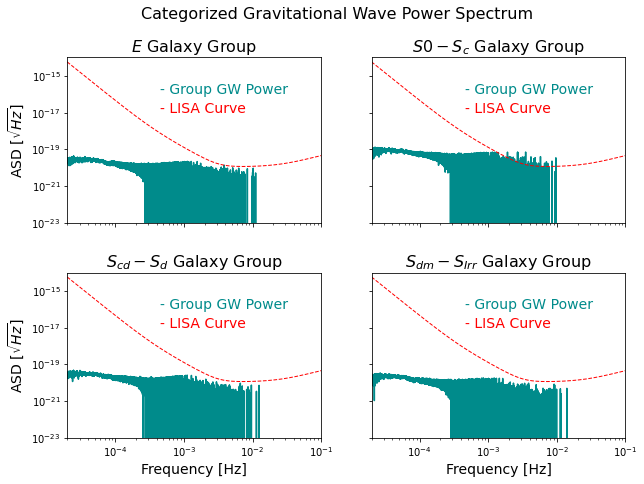

Group Power Spectrum Figure Saved.


<Figure size 432x288 with 0 Axes>

In [157]:
# ==================================
# Plotting randomized Power Spectrum
# (Group and total)
# ==================================

# Import Data
data_path = './generated_data/'
LISA_PSD = GW_calcs.lisa_PSD()
g1_power_tot = pd.read_hdf(data_path + 'group_power_rand_1.h5', key='power')
g2_power_tot = pd.read_hdf(data_path + 'group_power_rand_2.h5', key='power')
g3_power_tot = pd.read_hdf(data_path + 'group_power_rand_3.h5', key='power')
g4_power_tot = pd.read_hdf(data_path + 'group_power_rand_4.h5', key='power')
g_powers = [g1_power_tot, g2_power_tot, g3_power_tot, g4_power_tot]
print('Data imported.', '\n')

# Digitize power spectrum
LISA_freq = np.arange(1e-7, 1e-1, 1/(Tobs*yr_sec))
for i in range(len(g_powers)):
    print('Digitizing group spectrum', i+1)
    g_powers[i]['digits'] = np.digitize(g_powers[i].f_gw, LISA_freq)
    power = g_powers[i].groupby('digits').sum()['strain_2']
    power_group = np.zeros(len(LISA_freq))
    power_group[np.array(power.index.astype(int))-1] = power
    g_powers[i] = pd.DataFrame(np.vstack([LISA_freq, power_group]).T, columns=['f_gw', 'strain_2'])

# Figure Parameters
fs = 14 # fontsize
fig, ((ax1, ax2), 
      (ax3, ax4)) = plt.subplots(2, 2, sharey = False, 
                                 gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize = (10, 7))
fig.suptitle('Categorized Gravitational Wave Power Spectrum', fontsize = fs+2)

# Plotting Style
glx_names = ['$E$', '$S0 - S_c$', '$S_{cd} - S_d$','$S_{dm} - S_{Irr}$']
axs = [ax1, ax2, ax3, ax4]
text_x = 4.5e-4 # text location
text_y_up = 1e-16 # text location
text_y_dn = 1e-17 # text location
fs = 14 # fontsize
ax3.set_xlabel('Frequency [Hz]', fontsize=fs)
ax4.set_xlabel('Frequency [Hz]', fontsize=fs)
ax1.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)
ax3.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

# Plot the Grid
for i in range(4):
    axs[i].plot(g_powers[i].f_gw, 
               (g_powers[i].strain_2*Tobs*yr_sec)**0.5, color='darkcyan', rasterized=True)
    axs[i].plot(np.linspace(5e-6, 0.1, 10000), 
               (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')
    axs[i].set_title(glx_names[i]+' Galaxy Group', fontsize=fs+2)
    axs[i].text(text_x, text_y_up, 
                r'- '+'Group GW Power', color = 'darkcyan', fontsize=fs)
    axs[i].text(text_x, text_y_dn, 
                r'- LISA Curve', color = 'red', fontsize=fs)

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(2e-5, 1e-1)
    ax.set_ylim(1e-23, 1e-14)
    ax.set_xscale('log')
    ax.set_yscale('log')

plt.show()
save_plot_name = 'Group_GW_power_spec'
plt.savefig('figures/' + save_plot_name + '.png')
print('Group Power Spectrum Figure Saved.')

Computing Full Power Spectrum...
                  f_gw  strain_2
0         1.000000e-07       0.0
1         1.039620e-07       0.0
2         1.079239e-07       0.0
3         1.118859e-07       0.0
4         1.158479e-07       0.0
...                ...       ...
25239970  9.999998e-02       0.0
25239971  9.999999e-02       0.0
25239972  9.999999e-02       0.0
25239973  9.999999e-02       0.0
25239974  1.000000e-01       0.0

[25239975 rows x 2 columns]
Group binaries: 183706 197281 210625 184786 
 Power spectrum frequencies: 25239975
File saved as: full_power_tot_rand.h5


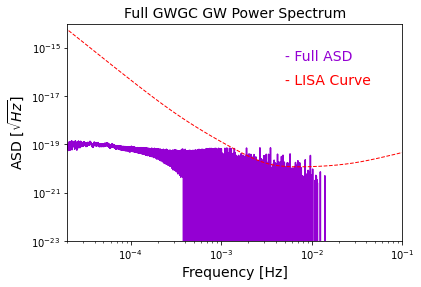

Randomized Full Power Spectrum Figure Saved
1.1529789413365544e-46


<Figure size 432x288 with 0 Axes>

In [166]:
# ======================
# Comoputing Total Power
# ======================
print('Computing Full Power Spectrum...')
full_power_tot_rand = g_powers[0] + g_powers[1] + g_powers[2] + g_powers[3]
full_power_tot_rand.f_gw = g_powers[0].f_gw
print(full_power_tot_rand)

print('Group binaries:',
      len(g1_power_tot), len(g2_power_tot), len(g3_power_tot), len(g4_power_tot), '\n',
      'Power spectrum frequencies:',
      len(full_power_tot_rand))

# Save Data
save_data_path = './generated_data/'
full_power_tot_rand.to_hdf(save_data_path + 'full_power_tot_rand' + '.h5', key='power')
print('File saved as:', 'full_power_tot_rand.h5')

# Plotting Total Power
plt.plot(full_power_tot_rand.f_gw, 
        (full_power_tot_rand.strain_2*Tobs*yr_sec)**0.5, color='darkviolet', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

# Plotting Styles
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)
plt.text(0.5e-2, 3e-16, r'- Full ASD', color = 'darkviolet', fontsize=fs)
plt.text(0.5e-2, 3e-17, r'- LISA Curve', color = 'red', fontsize=fs)
plt.title('Full GWGC GW Power Spectrum', fontsize=fs)

plt.show()
save_plot_name = 'Full_GW_power_spec_rand'
plt.savefig('figures/' + save_plot_name + '.png')
print('Randomized Full Power Spectrum Figure Saved')

Total frequencies = 25239975 

Computing Running Median...
Running Median Done. 

Saving power running median data...
Running median data saved! 

Plotting...
Figure saved as Full_GW_power_median


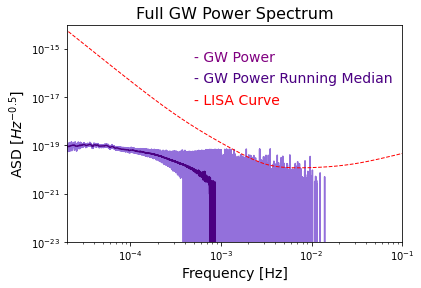

In [167]:
# =============================
# Power Spectrum Running Median
# =============================

save_data_path = './generated_data/'
full_power_tot = pd.read_hdf(save_data_path + 'full_power_tot_rand.h5', key='power')
full_power_tot['ASD'] = (full_power_tot.strain_2*Tobs*yr_sec)**0.5
full_power_tot['hf_2'] = full_power_tot.ASD**2
#full_power_tot = full_power_tot[full_power_tot['ASD'] > 0]
print('Total frequencies =', len(full_power_tot), '\n')

# Computing Running Median
win = 500 # Running median window width
print('Computing Running Median...')
full_PSD_median = full_power_tot.rolling(window=win).median()
full_PSD_median = full_PSD_median[win:]
print('Running Median Done.', '\n')

# Save Running Median Data
print('Saving power running median data...')
full_PSD_median.to_csv(save_data_path + 'full_PSD_median.csv')
print('Running median data saved!', '\n')

# Plotting running median
print('Plotting...')
fs = 14 # <====== fontsize
plt.plot(full_power_tot.f_gw, full_power_tot.ASD, color='mediumpurple', rasterized=True)
plt.plot(full_PSD_median.f_gw, full_PSD_median.hf_2**0.5, color = 'indigo')
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

xlabel = 5e-4 # Label x-asix location
plt.text(xlabel, 3e-16, r'- GW Power', color = 'purple', fontsize=fs)
plt.text(xlabel, 4e-17, r'- GW Power Running Median', color = 'indigo', fontsize=fs)
plt.text(xlabel, 5e-18, r'- LISA Curve', color = 'red', fontsize=fs)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$Hz^{-0.5}$]', fontsize=fs)
plt.title('Full GW Power Spectrum', fontsize=fs+2)

save_plot_name = 'Full_GW_power_median'
plt.savefig('figures/' + save_plot_name + '.png')
print('Figure saved as', save_plot_name)
plt.show()

Computing MW PSD Running Median...
Running Median Done. 

Saving MW power running median data...
Running median data saved! 

Plotting...
Figure saved as Comparison_GW_power_median


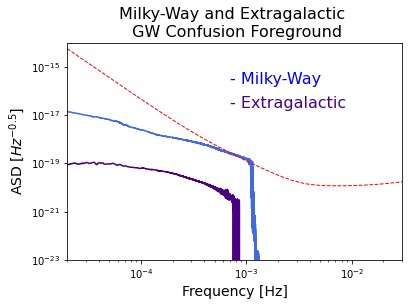

In [168]:
# =======================================
# MW - EG Confusion Foreground Comparison
# =======================================

# Extragalactic GW Data
eg_data_path = './generated_data/'
eg_PSD_median = pd.read_csv(eg_data_path + 'full_PSD_median.csv')

# MW GW Data(From COSMIC)
mw_data_path = './DATA/'
mw_power_tot = pd.read_hdf(mw_data_path+'COSMIC_MW_power_total.h5', key='power')
mw_power_tot = mw_power_tot.loc[mw_power_tot.strain_2 > 0]

# MW PSD Running Median
win = 500 # Running median window width
print('Computing MW PSD Running Median...')
mw_PSD_median = mw_power_tot.rolling(window=win).median()
mw_PSD_median = mw_PSD_median[win:]
print('Running Median Done.', '\n')

# Save MW Running Median Data
print('Saving MW power running median data...')
mw_PSD_median.to_csv('./generated_data/' + 'MW_full_PSD_median.csv')
print('Running median data saved!', '\n')

# =======================
# Plotting running median
# =======================

print('Plotting...')
fs = 14 # <====== fontsize
plt.plot(mw_PSD_median.f_gw, (mw_PSD_median.strain_2*Tobs*yr_sec)**0.5, color='royalblue')
plt.plot(eg_PSD_median.f_gw, eg_PSD_median.hf_2**0.5, color = 'indigo')

plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

xlabel = 7e-4 # Label x-asix location
plt.text(xlabel, 2e-16, r'- Milky-Way', color = 'blue', fontsize=fs+2)
plt.text(xlabel, 2e-17, r'- Extragalactic', color = 'indigo', fontsize=fs+2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 3e-2)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$Hz^{-0.5}$]', fontsize=fs)
plt.title('Milky-Way and Extragalactic \n GW Confusion Foreground', fontsize=fs+2)

save_plot_name = 'Comparison_GW_power_median'
plt.savefig('figures/' + save_plot_name + '.png')
print('Figure saved as', save_plot_name)
plt.show()

Power and running median data loaded. 

Computing confusion foreground...
Confusion foreground done. 

Plotting...


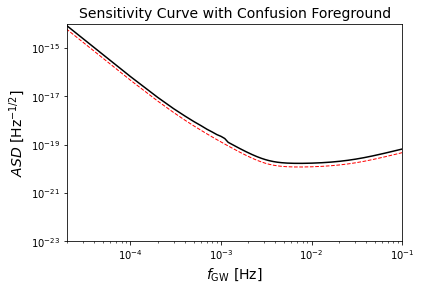

In [169]:
# ==============================
# Computing Confusion Foreground
# ==============================

# Loading power and running median data...
save_data_path = './generated_data/'
full_power_tot = pd.read_hdf(save_data_path + 'full_power_tot_rand.h5', key='power')
full_power_tot['hf_2'] = full_power_tot['strain_2']*Tobs*yr_sec
full_PSD_median = pd.read_csv(save_data_path + 'full_PSD_median.csv')
print('Power and running median data loaded.', '\n')


print('Computing confusion foreground...')
LISA_noise_median = LISA_PSD(full_PSD_median.f_gw)
full_PSD_median['hf_2'] = full_PSD_median['hf_2'] + LISA_noise_median

# Adding boundaries above and below to the foreground frequencies to compute SNRs
# (In case the frequency band is not completed)
PSD_median = full_PSD_median[['f_gw', 'hf_2']]
f_gw_add_up = np.linspace(0.1, 1, 1000)     # Upper boundry
f_gw_add_lo = np.linspace(1e-8, 1e-7, 1000) # Lower boundry
f_gw_add = np.append(f_gw_add_up, f_gw_add_lo)
PSD_median_noise_add = LISA_PSD(f_gw_add)

PSD_median = PSD_median.append(pd.DataFrame(np.vstack([f_gw_add, PSD_median_noise_add]).T, 
                                            columns=['f_gw', 'hf_2']))
extraglc_background_interp = interp1d(PSD_median.f_gw, PSD_median.hf_2)
print('Confusion foreground done.', '\n')

# Import COSMIC MW Confusion Foreground
COSMIC_MW_foreground = pd.read_csv('./DATA/' + 'COSMIC_MW_foreground.csv')
mw_foregound_interp = interp1d(COSMIC_MW_foreground.f_gw, COSMIC_MW_foreground.hf_2)

# Combine Milky-Way and Extragalactic
background_PSD = (extraglc_background_interp(np.linspace(1e-8, 1, 10000)) +
                  mw_foregound_interp(np.linspace(1e-8, 1, 10000)))    
background_interp = interp1d(np.linspace(1e-8, 1, 10000), background_PSD)


# Background_interp plotting
print('Plotting...')
fs = 14 # <====== fontsize
plt.plot(np.linspace(1e-8, 1, 10000), 
        (background_interp(np.linspace(1e-8, 1, 10000)))**0.5, '-', color='black')
plt.plot(np.linspace(1e-8, 1, 10000), 
        (LISA_PSD(np.linspace(1e-8, 1, 10000)))**0.5, lw=1, linestyle='--', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$f_{\rm{GW}}$ [Hz]', size=fs)
plt.ylabel(r'$ASD$ [Hz$^{-1/2}$]', size=fs)
plt.title('Sensitivity Curve with Confusion Foreground', fontsize=fs)
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.show()

Part 4: Loud Sources in M31
==

Power and running median data loaded. 

Loud systems: 1


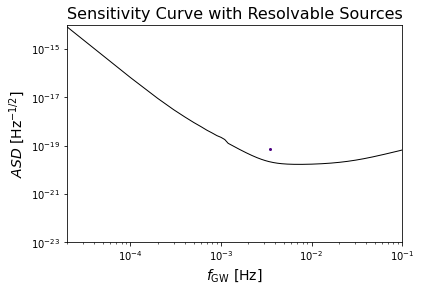

In [218]:
# =======================
# Find Resolvable Sources 
# =======================

# Loading power and running median data...
save_data_path = './generated_data/'
full_power_tot = pd.read_hdf(save_data_path + 'full_power_tot_rand.h5', key='power')
full_PSD_median = pd.read_csv(save_data_path + 'full_PSD_median.csv')
print('Power and running median data loaded.', '\n')

# Loud source condition: SNR > 7
SNR_lim = 7
dat_loud = full_power_tot.loc[full_power_tot.strain_2*Tobs*yr_sec > SNR_lim*background_interp(full_power_tot.f_gw)]
print('Loud systems: {}'.format(len(dat_loud)))

# Plotting
fs = 14 # <====== fontsize
plt.plot(dat_loud.f_gw, (dat_loud.strain_2*Tobs*yr_sec)**0.5, '.', markersize = 4, color='indigo')
plt.plot(np.linspace(1e-8, 1, 10000), 
        (background_interp(np.linspace(1e-8, 1, 10000)))**0.5, lw=1, color='black')
plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel(r'$f_{\rm{GW}}$ [Hz]', size=fs)
plt.ylabel(r'$ASD$ [Hz$^{-1/2}$]', size=fs)
plt.title('Sensitivity Curve with Resolvable Sources', fontsize=fs+2)
plt.show()

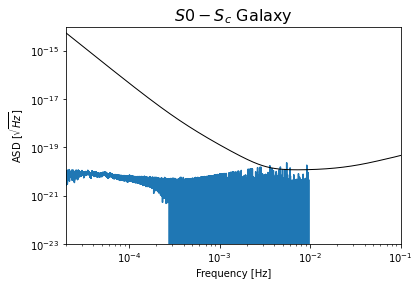

In [224]:
# Import Gravitational Wave power spectrum data
power_file = 'glx_power_2.h5'
base_power = pd.read_hdf(data_path + power_file, key='power')

LISA_PSD = GW_calcs.lisa_PSD()
plt.plot(base_power.f_gw, (base_power.strain_2*Tobs*yr_sec)**0.5, rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [$\sqrt{Hz}$]')
plt.title('$S0 - S_c$' + ' Galaxy', fontsize=fs+2)
plt.show()

scale rate = 18.986590720303784


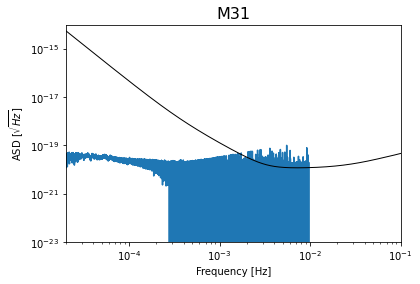

In [225]:
m31_dist = 0.795 # in Mpc
m31_mass = 12*1e10 # in solar mass
scale_rate = m31_mass/1e10 / m31_dist**2
print('scale rate =', scale_rate)

m31_power = base_power
m31_power['strain_2'] = base_power.strain_2 * scale_rate
    
LISA_PSD = GW_calcs.lisa_PSD()
plt.plot(m31_power.f_gw, (m31_power.strain_2*Tobs*yr_sec)**0.5, rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, color='black')

plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [$\sqrt{Hz}$]')
plt.title('M31', fontsize=fs+2)
plt.show()

Total frequencies = 25239975 

Computing Running Median...
Running Median Done. 

Saving power running median data...
Running median data saved! 

Plotting...
Figure saved as M31_GW_power_median


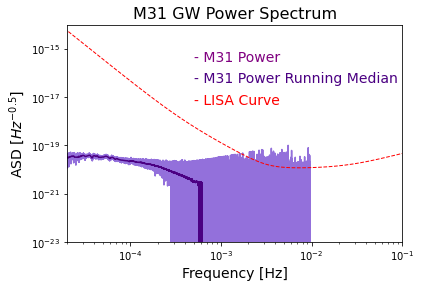

In [231]:
# =============================
# Power Spectrum Running Median
# =============================

m31_power['ASD'] = (m31_power.strain_2*Tobs*yr_sec)**0.5
m31_power['hf_2'] = m31_power.ASD**2
print('Total frequencies =', len(m31_power), '\n')

# Computing Running Median
win = 500 # Running median window width
print('Computing Running Median...')
m31_median = m31_power.rolling(window=win).median()
m31_median = m31_median[win:]
print('Running Median Done.', '\n')

# Save Running Median Data
print('Saving power running median data...')
m31_median.to_csv(save_data_path + 'm31_median.csv')
print('Running median data saved!', '\n')

# Plotting running median
print('Plotting...')
fs = 14 # <====== fontsize
plt.plot(m31_power.f_gw, m31_power.ASD, color='mediumpurple', rasterized=True)
plt.plot(m31_median.f_gw, m31_median.hf_2**0.5, color = 'indigo')
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

xlabel = 5e-4 # Label x-asix location
plt.text(xlabel, 3e-16, r'- M31 Power', color = 'purple', fontsize=fs)
plt.text(xlabel, 4e-17, r'- M31 Power Running Median', color = 'indigo', fontsize=fs)
plt.text(xlabel, 5e-18, r'- LISA Curve', color = 'red', fontsize=fs)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$Hz^{-0.5}$]', fontsize=fs)
plt.title('M31 GW Power Spectrum', fontsize=fs+2)

save_plot_name = 'M31_GW_power_median'
plt.savefig('figures/' + save_plot_name + '.png')
print('Figure saved as', save_plot_name)
plt.show()

Computing MW PSD Running Median...
Running Median Done. 

Saving MW power running median data...
Running median data saved! 

Plotting...
Figure saved as Comparison_GW_power_median


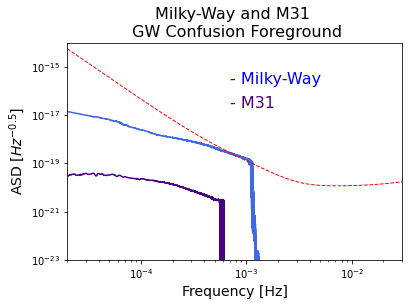

In [232]:
# =======================================
# MW - EG Confusion Foreground Comparison
# =======================================

# Extragalactic GW Data
m31_data_path = './generated_data/'
m31_PSD_median = pd.read_csv(m31_data_path + 'm31_median.csv')

# MW GW Data(From COSMIC)
mw_data_path = './DATA/'
mw_power_tot = pd.read_hdf(mw_data_path+'COSMIC_MW_power_total.h5', key='power')
mw_power_tot = mw_power_tot.loc[mw_power_tot.strain_2 > 0]

# MW PSD Running Median
win = 500 # Running median window width
print('Computing MW PSD Running Median...')
mw_PSD_median = mw_power_tot.rolling(window=win).median()
mw_PSD_median = mw_PSD_median[win:]
print('Running Median Done.', '\n')

# Save MW Running Median Data
print('Saving MW power running median data...')
mw_PSD_median.to_csv('./generated_data/' + 'MW_full_PSD_median.csv')
print('Running median data saved!', '\n')

# =======================
# Plotting running median
# =======================

print('Plotting...')
fs = 14 # <====== fontsize
plt.plot(mw_PSD_median.f_gw, (mw_PSD_median.strain_2*Tobs*yr_sec)**0.5, color='royalblue')
plt.plot(m31_PSD_median.f_gw, m31_PSD_median.hf_2**0.5, color = 'indigo')

plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

xlabel = 7e-4 # Label x-asix location
plt.text(xlabel, 2e-16, r'- Milky-Way', color = 'blue', fontsize=fs+2)
plt.text(xlabel, 2e-17, r'- M31', color = 'indigo', fontsize=fs+2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 3e-2)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$Hz^{-0.5}$]', fontsize=fs)
plt.title('Milky-Way and M31 \n GW Confusion Foreground', fontsize=fs+2)

save_plot_name = 'Comparison_GW_power_median'
plt.savefig('figures/' + save_plot_name + '.png')
print('Figure saved as', save_plot_name)
plt.show()

Power and running median data loaded. 

Computing confusion foreground...
Confusion foreground done. 

Plotting...


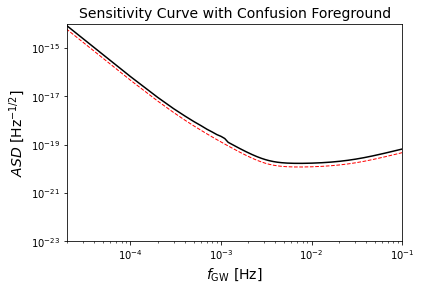

In [233]:
# ==============================
# Computing Confusion Foreground
# ==============================

# Loading power and running median data...
save_data_path = './generated_data/'
m31_power_tot = pd.read_hdf(save_data_path + 'full_power_tot_rand.h5', key='power')
full_power_tot['hf_2'] = full_power_tot['strain_2']*Tobs*yr_sec
full_PSD_median = pd.read_csv(save_data_path + 'full_PSD_median.csv')
print('Power and running median data loaded.', '\n')


print('Computing confusion foreground...')
LISA_noise_median = LISA_PSD(full_PSD_median.f_gw)
m31_PSD_median['hf_2'] = m31_PSD_median['hf_2'] + LISA_noise_median

# Adding boundaries above and below to the foreground frequencies to compute SNRs
# (In case the frequency band is not completed)
PSD_median = m31_PSD_median[['f_gw', 'hf_2']]
f_gw_add_up = np.linspace(0.1, 1, 1000)     # Upper boundry
f_gw_add_lo = np.linspace(1e-8, 1e-7, 1000) # Lower boundry
f_gw_add = np.append(f_gw_add_up, f_gw_add_lo)
PSD_median_noise_add = LISA_PSD(f_gw_add)

PSD_median = PSD_median.append(pd.DataFrame(np.vstack([f_gw_add, PSD_median_noise_add]).T, 
                                            columns=['f_gw', 'hf_2']))
m31_background_interp = interp1d(PSD_median.f_gw, PSD_median.hf_2)
print('Confusion foreground done.', '\n')

# Import COSMIC MW Confusion Foreground
COSMIC_MW_foreground = pd.read_csv('./DATA/' + 'COSMIC_MW_foreground.csv')
mw_foregound_interp = interp1d(COSMIC_MW_foreground.f_gw, COSMIC_MW_foreground.hf_2)

# Combine Milky-Way and M31
background_PSD = (extraglc_background_interp(np.linspace(1e-8, 1, 10000)) +
                  mw_foregound_interp(np.linspace(1e-8, 1, 10000)))    
background_interp = interp1d(np.linspace(1e-8, 1, 10000), background_PSD)


# Background_interp plotting
print('Plotting...')
fs = 14 # <====== fontsize
plt.plot(np.linspace(1e-8, 1, 10000), 
        (background_interp(np.linspace(1e-8, 1, 10000)))**0.5, '-', color='black')
plt.plot(np.linspace(1e-8, 1, 10000), 
        (LISA_PSD(np.linspace(1e-8, 1, 10000)))**0.5, lw=1, linestyle='--', color='red')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$f_{\rm{GW}}$ [Hz]', size=fs)
plt.ylabel(r'$ASD$ [Hz$^{-1/2}$]', size=fs)
plt.title('Sensitivity Curve with Confusion Foreground', fontsize=fs)
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.show()

Loud systems: 11


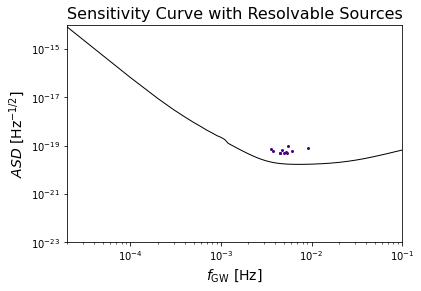

In [234]:
# ==============================
# Find Resolvable Sources in M31 
# ==============================

# Loud source condition: SNR > 7

SNR_lim = 7
dat_loud = m31_power.loc[m31_power.strain_2*Tobs*yr_sec > SNR_lim*background_interp(m31_power.f_gw)]
print('Loud systems: {}'.format(len(dat_loud)))

# Plotting
fs = 14 # <====== fontsize
plt.plot(dat_loud.f_gw, (dat_loud.strain_2*Tobs*yr_sec)**0.5, '.', markersize = 4, color='indigo')
plt.plot(np.linspace(1e-8, 1, 10000), 
        (background_interp(np.linspace(1e-8, 1, 10000)))**0.5, lw=1, color='black')
plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel(r'$f_{\rm{GW}}$ [Hz]', size=fs)
plt.ylabel(r'$ASD$ [Hz$^{-1/2}$]', size=fs)
plt.title('Sensitivity Curve with Resolvable Sources', fontsize=fs+2)
plt.show()